Maastricht_University_logo.svg

# Information Retrieval and Text Mining Course
## Tutorial 07 — Information Extraction: Building Structured Representations from Text (Part 2)

**Author:** Jan Scholtes and Gijs Wijngaard

**Edition 2025-2026**

Department of Advanced Computer Sciences — Maastricht University

Welcome to Tutorial 07 on **Information Extraction**. In this tutorial, you will learn and practice several methods for extracting structured information from text. The topics covered are:

1. **Named Entity Recognition (NER) with NLTK** — traditional POS tagging, chunking, and entity extraction.
2. **BERT: Tokenizers and Embeddings** — understanding context-sensitive representations using the BERT Transformer architecture.
3. **Pre-trained BERT for NER** — using a HuggingFace pipeline with the `dslim/bert-base-NER` model.
4. **Fine-tuning BERT for NER** — training BERT on the CoNLL-2003 dataset.
5. **Entity Normalization and String Matching** — Levenshtein, Jaro-Winkler, Jaccard, and Soft TF-IDF.
6. **From Text to Knowledge Graphs** — extracting triples and building knowledge graphs with NetworkX.
7. **Applied Pipeline: Knowledge Graph from Your Corpus** — building a KG from the Sherlock Holmes corpus you indexed in Tutorial 03.
8. **RAG Retrieval Foundation: FAISS Vector Store** — embedding your corpus and building a dense retrieval index for use in Tutorial 11.
9. **Atomic Facts & QA Test Set** — decomposing text into verifiable claims and generating question-answer pairs for RAGAS evaluation.

At the end you will find the **Exercises** section with graded assignments.

> **Note:** This course is about Information Retrieval, Text Mining, and Conversational Search — not about programming skills. The code cells below are meant to show you *how* these methods work in practice using Python libraries. Focus on understanding the **concepts** and **results**.

> **Cross-notebook arc:** In Tutorial 03 you built a search engine over your own text corpus. In Sections 7–9 of this tutorial, we use that same corpus to build a Knowledge Graph, a vector store, and a test set. In Tutorial 11, you will use all of these to build and evaluate a RAG chatbot.

## Library Installation

We install all required packages in a single cell. Run this cell once at the beginning of your session.

In [169]:
# Install required packages
import subprocess, sys

packages = [
    "svgling", "accelerate", "datasets", "seqeval", "evaluate",
    "python-Levenshtein", "networkx",
    "sentence-transformers", "faiss-cpu",
]
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("All packages installed successfully.")

All packages installed successfully.


## Library Imports

All imports are grouped here so the notebook is easy to set up and run.

In [ ]:
# Standard library
import os
import re
import glob
import json
import random
from collections import defaultdict, Counter
from pprint import pprint

# Data & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLTK
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('maxent_ne_chunker_tab', quiet=True)
nltk.download('words', quiet=True)
from nltk import word_tokenize, pos_tag, sent_tokenize, ne_chunk, RegexpParser
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.tree import Tree

# Visualization for parse trees
import svgling

# PyTorch
import torch

# HuggingFace Transformers
from transformers import (
    BertTokenizer, BertTokenizerFast, BertModel,
    BertForSequenceClassification, BertForTokenClassification,
    AutoTokenizer, AutoModelForTokenClassification,
    Trainer, TrainingArguments, DataCollatorForTokenClassification,
    pipeline
)

# Datasets
from datasets import load_dataset

# Evaluation
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import evaluate

# String matching
import Levenshtein

# Knowledge graphs
import networkx as nx

# Dense retrieval (for §7-§9: RAG foundation & atomic facts)
from sentence_transformers import SentenceTransformer
import faiss

# Reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("All libraries loaded successfully.")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries loaded successfully.
PyTorch version: 2.10.0+cpu
CUDA available: False


---
# 1. Named Entity Recognition with NLTK

Named Entity Recognition (NER) is the task of locating and classifying named entities in text into predefined categories such as **person names**, **organizations**, **locations**, **dates**, **medical codes**, etc.

**Information Extraction** aims to identify several types of structured elements from text:
- **Entities**: people, companies, locations, products, genes, etc.
- **Attributes**: properties of entities (age, title, address, etc.)
- **Facts**: relationships between entities (e.g., a person works for a company)
- **Events**: activities involving entities (e.g., a person travels to a location)
- **Concepts**: harder-to-define patterns with often ambiguous meanings

**Key challenges** include:
- Unknown words (dictionaries are never complete)
- Same words occurring as different entity types (e.g., "Apple" as company vs. fruit)
- Boundary problems (e.g., "City University of New York")
- Multiple textual forms for one entity (e.g., "Barack Obama", "B. Obama", "The President")
- Abbreviations (e.g., IBM, HP, WSJ)

State-of-the-art NER systems for English produce near-human performance (F-measure ~93% vs. ~97% for human annotators).

## 1.1 POS Tagging

Part-of-Speech (POS) tagging assigns a grammatical tag (noun, verb, adjective, etc.) to each word in a sentence. POS tags form the basis for many NER pipelines, since named entities are typically nouns or noun phrases.

In [171]:
# POS tagging with NLTK
sentence = "IRTM is an interesting course on Information Retrieval, Text Mining, and Conversational Search"
tokens = word_tokenize(sentence)
tagged = pos_tag(tokens)
print(tagged)

[('IRTM', 'NNP'), ('is', 'VBZ'), ('an', 'DT'), ('interesting', 'JJ'), ('course', 'NN'), ('on', 'IN'), ('Information', 'NNP'), ('Retrieval', 'NNP'), (',', ','), ('Text', 'NNP'), ('Mining', 'NNP'), (',', ','), ('and', 'CC'), ('Conversational', 'NNP'), ('Search', 'NNP')]


## 1.2 Chunking

Chunking groups words into phrases based on their POS tags using regular-expression patterns. For example, we can extract **noun phrases (NP)** that consist of adjacent nouns.

The **IOB** tagging scheme labels each token as:
- **B** (Begin) — start of a chunk
- **I** (Inside) — inside a chunk
- **O** (Outside) — not part of any chunk

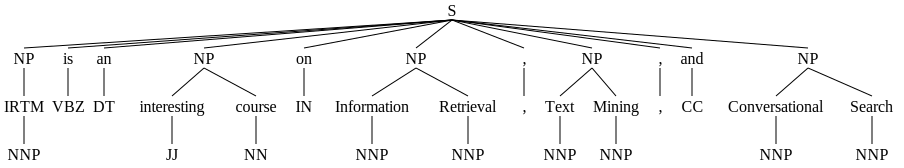

In [172]:
# Define a chunking grammar: noun phrases = zero or more adjectives followed by one or more nouns
grammar = "NP: {<JJ>*<NN.*>+}"
parser = RegexpParser(grammar)

tree = parser.parse(tagged)
tree  # svgling will render this as a tree diagram

In [173]:
# Convert tree to IOB tags
iob_tags = tree2conlltags(tree)
pprint(iob_tags)

[('IRTM', 'NNP', 'B-NP'),
 ('is', 'VBZ', 'O'),
 ('an', 'DT', 'O'),
 ('interesting', 'JJ', 'B-NP'),
 ('course', 'NN', 'I-NP'),
 ('on', 'IN', 'O'),
 ('Information', 'NNP', 'B-NP'),
 ('Retrieval', 'NNP', 'I-NP'),
 (',', ',', 'O'),
 ('Text', 'NNP', 'B-NP'),
 ('Mining', 'NNP', 'I-NP'),
 (',', ',', 'O'),
 ('and', 'CC', 'O'),
 ('Conversational', 'NNP', 'B-NP'),
 ('Search', 'NNP', 'I-NP')]


## 1.3 Named Entity Recognition with `ne_chunk`

NLTK's `ne_chunk` function performs NER by identifying named entities in POS-tagged text. It can operate in two modes:
- `binary=True` — detects named entities without classifying them
- `binary=False` — categorizes entities into types: PERSON, ORGANIZATION, GPE (Geo-Political Entity), etc.

In [174]:
# Let's try NER on a longer, more interesting text
article = """Bill Gates is an American business magnate, software developer, and philanthropist. \
He is best known as the co-founder of Microsoft Corporation with his childhood friend Paul Allen. \
During his career at Microsoft, Gates held the positions of chairman, chief executive officer (CEO), \
president, and chief software architect, while also being the largest individual shareholder until \
May 2014. Jan Scholtes teaches a course on Information Retrieval and Text Mining at Maastricht University \
and was founder and CEO of ZyLAB Technologies amd worked as board member with Mind District. \
Today, he works as venture partner AI with Endeit Capital in Amsterdam, the Netherlands and with IPRally in Helsinki, Finland as board memner. \
In December 2023, ChatGPT became the fastest-growing consumer application, recording over 100 million users only \
two months after its launch in November 2022. ChatGPT is a natural language processing tool powered by \
GPT, which is an LLM developed by OpenAI."""

print(article[:200], "...")

Bill Gates is an American business magnate, software developer, and philanthropist. He is best known as the co-founder of Microsoft Corporation with his childhood friend Paul Allen. During his career  ...


In [175]:
# Binary NER (just detect named entities)
sentences = sent_tokenize(article)
tokenized_sents = [word_tokenize(s) for s in sentences]
tagged_sents = [pos_tag(t) for t in tokenized_sents]
chunked_sents = [ne_chunk(t, binary=True) for t in tagged_sents]

for tree in chunked_sents:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            print(chunk)

(NE Bill/NNP Gates/NNP)
(NE American/JJ)
(NE Microsoft/NNP Corporation/NNP)
(NE Paul/NNP Allen/NNP)
(NE Microsoft/NNP)
(NE Gates/NNP)
(NE Jan/NNP Scholtes/NNP)
(NE Text/NNP Mining/NNP)
(NE Maastricht/NNP University/NNP)
(NE CEO/NNP)
(NE ZyLAB/NNP Technologies/NNPS)
(NE Mind/NNP District/NNP)
(NE Endeit/NNP Capital/NNP)
(NE Amsterdam/NNP)
(NE Netherlands/NNP)
(NE IPRally/NNP)
(NE Helsinki/NNP)
(NE Finland/NNP)
(NE ChatGPT/NNP)
(NE ChatGPT/NNP)
(NE GPT/NNP)
(NE OpenAI/NNP)


In [176]:
# Categorized NER (classify entity types)
chunked_sents_cat = [ne_chunk(t, binary=False) for t in tagged_sents]

for tree in chunked_sents_cat:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            print(f"{chunk.label():15s} {' '.join(c[0] for c in chunk)}")

PERSON          Bill
GPE             Gates
GPE             American
ORGANIZATION    Microsoft Corporation
PERSON          Paul Allen
ORGANIZATION    Microsoft
PERSON          Gates
ORGANIZATION    CEO
PERSON          Jan
GPE             Scholtes
PERSON          Text Mining
ORGANIZATION    Maastricht University
ORGANIZATION    CEO
ORGANIZATION    ZyLAB Technologies
PERSON          Mind District
PERSON          Endeit Capital
GPE             Amsterdam
GPE             Netherlands
ORGANIZATION    IPRally
GPE             Helsinki
GPE             Finland
ORGANIZATION    ChatGPT
ORGANIZATION    ChatGPT
ORGANIZATION    GPT
ORGANIZATION    LLM
ORGANIZATION    OpenAI


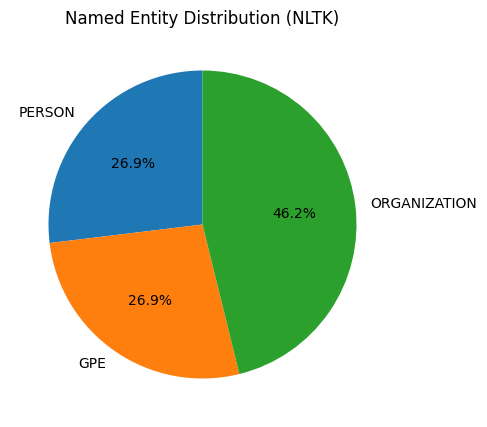

In [177]:
# Visualize entity distribution
entity_counts = defaultdict(int)
for tree in chunked_sents_cat:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            entity_counts[chunk.label()] += 1

labels = list(entity_counts.keys())
sizes = list(entity_counts.values())

plt.figure(figsize=(8, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Named Entity Distribution (NLTK)")
plt.show()

**Observation:** NLTK's NER is rule-based and uses the MaxEnt classifier. While it provides a quick baseline, it misses many entities and sometimes mis-classifies them. Traditional approaches like HMM, MEMM, and CRF also struggle with long-range dependencies, ambiguity, and out-of-vocabulary words.

This motivates the use of deep learning approaches like **BERT**, which we explore next.

---
# 2. BERT: Tokenizers and Embeddings

**BERT** (Bidirectional Encoder Representations from Transformers) is a Transformer-based model that revolutionized NLP. Key properties:

- **Bidirectional context**: unlike older models (LSTMs) that read text left-to-right or stitch two directions together, BERT sees the entire sentence simultaneously using *self-attention*.
- **Contextualized embeddings**: the word "Apple" gets different vector representations depending on whether the sentence is about fruit or the company.
- **WordPiece tokenization**: handles out-of-vocabulary words by splitting them into known subword units (e.g., "HuggingFace" → ["Hugging", "##Face"]).
- **Pre-trained** on Masked Language Modeling (MLM) and Next Sentence Prediction (NSP) tasks, then **fine-tuned** for downstream tasks like NER, sentiment analysis, and question answering.

The [HuggingFace Transformers](https://huggingface.co/docs/transformers/) library provides easy access to thousands of pre-trained models.

## 2.1 Vocabulary and Tokenizers

A tokenizer converts raw text into numerical token IDs that the model can process. BERT uses a **WordPiece** tokenizer with special tokens:
- `[CLS]` — placed at the beginning of every input (used for classification tasks)
- `[SEP]` — separates sentence pairs or marks the end
- `[PAD]` — pads shorter sequences to match the longest in a batch

In [178]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize a sentence
text = "Information Retrieval and Text Mining is an exciting field."
tokenized_text = tokenizer.tokenize(text)
print("Tokens:", tokenized_text)

Tokens: ['information', 'retrieval', 'and', 'text', 'mining', 'is', 'an', 'exciting', 'field', '.']


In [179]:
# Add special tokens and convert to IDs
marked_text = ['[CLS]'] + tokenized_text + ['[SEP]']
input_ids = tokenizer.convert_tokens_to_ids(marked_text)
print("Marked tokens:", marked_text)
print("Token IDs:    ", input_ids)

Marked tokens: ['[CLS]', 'information', 'retrieval', 'and', 'text', 'mining', 'is', 'an', 'exciting', 'field', '.', '[SEP]']
Token IDs:     [101, 2592, 26384, 1998, 3793, 5471, 2003, 2019, 10990, 2492, 1012, 102]


In [180]:
# Explore the vocabulary
print("Vocab size:", len(tokenizer.vocab))
print("Sample entries (5000-5019):", list(tokenizer.vocab.keys())[5000:5020])

# Round-trip: IDs back to tokens
reconstructed = tokenizer.convert_ids_to_tokens(input_ids)
print("Reconstructed:", reconstructed)

Vocab size: 30522
Sample entries (5000-5019): ['##tory', '##zog', 'uncle', 'misses', '##ɴ', 'signature', '##rry', 'tan', 'southeast', '##lley', '##chemical', 'chests', 'inhaled', 'subdivision', '##idge', 'า', 'conducting', 'operate', 'rating', '##osh']
Reconstructed: ['[CLS]', 'information', 'retrieval', 'and', 'text', 'mining', 'is', 'an', 'exciting', 'field', '.', '[SEP]']


## 2.2 Getting Embeddings from BERT

BERT-base has 12 Transformer encoder layers, each producing 768-dimensional hidden states. We can extract these embeddings to understand how BERT represents words in context.

In [181]:
# Load the BERT model
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # set to evaluation mode

# Prepare input: "I love AI"
sentence = "I love AI"
tokens = tokenizer.tokenize(sentence)
tokens = ['[CLS]'] + tokens + ['[SEP]']

# Pad to length 7
while len(tokens) < 7:
    tokens.append('[PAD]')

# Create attention mask (1 = real token, 0 = padding)
attention_mask = [1 if t != '[PAD]' else 0 for t in tokens]

# Convert to tensor
token_ids = torch.tensor([tokenizer.convert_tokens_to_ids(tokens)])
attention_mask = torch.tensor([attention_mask])

print(f"Tokens: {tokens}")
print(f"IDs:    {token_ids[0].tolist()}")
print(f"Mask:   {attention_mask[0].tolist()}")

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1142.01it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Tokens: ['[CLS]', 'i', 'love', 'ai', '[SEP]', '[PAD]', '[PAD]']
IDs:    [101, 1045, 2293, 9932, 102, 0, 0]
Mask:   [1, 1, 1, 1, 1, 0, 0]


In [182]:
# Get embeddings
with torch.no_grad():
    outputs = model(token_ids, attention_mask=attention_mask)

last_hidden_state = outputs.last_hidden_state
pooler_output = outputs.pooler_output

print(f"Last hidden state shape: {last_hidden_state.shape}")  # [batch=1, seq_len=7, hidden=768]
print(f"Pooler output shape:     {pooler_output.shape}")      # [batch=1, hidden=768]
print(f"\nThe embedding for token '{tokens[3]}' (index 3) has shape: {last_hidden_state[0, 3, :].shape}")

Last hidden state shape: torch.Size([1, 7, 768])
Pooler output shape:     torch.Size([1, 768])

The embedding for token 'ai' (index 3) has shape: torch.Size([768])


## 2.3 Extracting Embeddings from All Encoder Layers

BERT-base produces 13 sets of hidden states:
- `hidden_states[0]` = initial word embedding layer (non-contextual)
- `hidden_states[1]` through `hidden_states[12]` = output of each of the 12 encoder layers

Research has shown that different layers capture different linguistic features. Concatenating or averaging specific layers can produce better results for different tasks (see Devlin et al., 2019).

In [183]:
# Reload model with output_hidden_states=True
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()

with torch.no_grad():
    outputs = model(token_ids, attention_mask=attention_mask)

hidden_states = outputs.hidden_states
print(f"Number of hidden state layers: {len(hidden_states)}")  # 13
print(f"Shape of each layer: {hidden_states[0].shape}")         # [1, 7, 768]

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1097.87it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of hidden state layers: 13
Shape of each layer: torch.Size([1, 7, 768])


In [184]:
# Compare embeddings from different layers for the word "AI" (index 3)
print("Comparing 'AI' embedding across layers:")
for layer_idx in [0, 1, 6, 11, 12]:
    embedding = hidden_states[layer_idx][0, 3, :]
    print(f"  Layer {layer_idx:2d}: mean={embedding.mean():.4f}, std={embedding.std():.4f}, norm={embedding.norm():.4f}")

Comparing 'AI' embedding across layers:
  Layer  0: mean=0.0038, std=0.6070, norm=16.8115
  Layer  1: mean=-0.0260, std=0.7191, norm=19.9278
  Layer  6: mean=-0.0271, std=0.7972, norm=22.0908
  Layer 11: mean=-0.0303, std=0.7294, norm=20.2185
  Layer 12: mean=-0.0104, std=0.5315, norm=14.7215


---
# 3. Pre-trained BERT for Named Entity Recognition

Instead of training a model from scratch, we can use **pre-trained NER models** from HuggingFace. The `dslim/bert-base-NER` model is a `bert-base-cased` model fine-tuned on the CoNLL-2003 dataset. It recognizes four entity types:

| Label | Entity Type |
|-------|------------|
| **PER** | Person |
| **ORG** | Organization |
| **LOC** | Location |
| **MISC** | Miscellaneous |

**Why BERT for NER?**
- **Contextualized embeddings**: "Apple" gets different representations depending on context (company vs. fruit).
- **True bidirectionality**: every layer sees every other word simultaneously via self-attention.
- **WordPiece handles OOV**: unknown words are broken into meaningful subword units.
- **Long-range dependencies**: self-attention connects words regardless of distance.

**BERT vs. LLMs (GPT-4, etc.) for production NER:**
- BERT is ~100x faster than large LLMs for tagging tasks
- BERT can run locally (privacy-preserving)
- BERT provides structured 1:1 token-to-label mapping (ideal for Knowledge Graphs)

In [185]:
# Load a pre-trained NER pipeline
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

# Test on our article text
results = ner_pipeline(article)

# Display results in a DataFrame
df_ner = pd.DataFrame(results)
print(df_ner[['entity_group', 'word', 'score']].to_string(index=False))

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1080.38it/s, Materializing param=classifier.weight]                                      
BertForTokenClassification LOAD REPORT from: dslim/bert-base-NER
Key                      | Status     |  | 
-------------------------+------------+--+-
bert.pooler.dense.weight | UNEXPECTED |  | 
bert.pooler.dense.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


entity_group                  word    score
         PER            Bill Gates 0.999707
        MISC              American 0.999398
         ORG Microsoft Corporation 0.999310
         PER            Paul Allen 0.999706
         ORG             Microsoft 0.998627
         PER                 Gates 0.997068
         PER          Jan Scholtes 0.997727
        MISC           Information 0.392590
         ORG             Retrieval 0.710030
         ORG                  Text 0.478225
        MISC                Mining 0.653167
         ORG Maastricht University 0.974424
         ORG    ZyLAB Technologies 0.947463
         ORG         Mind District 0.996483
         ORG                    AI 0.504350
         ORG        Endeit Capital 0.996158
         LOC             Amsterdam 0.999042
         LOC           Netherlands 0.999087
         ORG               IPRally 0.988230
         LOC              Helsinki 0.999090
         LOC               Finland 0.999572
         ORG                   C

In [186]:
# Compare BERT NER results with NLTK NER on the same text
print("=" * 60)
print("BERT NER Results:")
print("=" * 60)
for r in results:
    print(f"  {r['entity_group']:8s} {r['word']:30s} (score: {r['score']:.3f})")

print()
print("=" * 60)
print("NLTK NER Results (for comparison):")
print("=" * 60)
for tree in chunked_sents_cat:
    for chunk in tree:
        if hasattr(chunk, 'label'):
            entity_text = ' '.join(c[0] for c in chunk)
            print(f"  {chunk.label():15s} {entity_text}")

BERT NER Results:
  PER      Bill Gates                     (score: 1.000)
  MISC     American                       (score: 0.999)
  ORG      Microsoft Corporation          (score: 0.999)
  PER      Paul Allen                     (score: 1.000)
  ORG      Microsoft                      (score: 0.999)
  PER      Gates                          (score: 0.997)
  PER      Jan Scholtes                   (score: 0.998)
  MISC     Information                    (score: 0.393)
  ORG      Retrieval                      (score: 0.710)
  ORG      Text                           (score: 0.478)
  MISC     Mining                         (score: 0.653)
  ORG      Maastricht University          (score: 0.974)
  ORG      ZyLAB Technologies             (score: 0.947)
  ORG      Mind District                  (score: 0.996)
  ORG      AI                             (score: 0.504)
  ORG      Endeit Capital                 (score: 0.996)
  LOC      Amsterdam                      (score: 0.999)
  LOC      Ne

**Observation:** BERT-based NER is significantly more accurate than NLTK's rule-based approach. BERT correctly identifies entities even in complex contexts, handles multi-word entities better, and provides confidence scores.

---
# 4. Fine-tuning BERT for Named Entity Recognition

While pre-trained NER models work well for general entities, you may need to fine-tune BERT on your own data for domain-specific NER (e.g., medical entities, legal terms, financial instruments).

Here we fine-tune BERT on the **CoNLL-2003** dataset, which contains POS tags, syntactic chunk tags, and NER tags. The NER tags use the IOB2 format with these entity types: PER, ORG, LOC, MISC.

The key difference from sequence classification:
- `BertForSequenceClassification` classifies the **entire sentence** (one label per sentence)
- `BertForTokenClassification` classifies **each token** (one label per token — needed for NER)

In [187]:
# Load the CoNLL-2003 dataset
try:
    dataset = load_dataset("conll2003")
except Exception:
    dataset = load_dataset("eriktks/conll2003")
print(dataset)

Using the latest cached version of the dataset since eriktks/conll2003 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\jcsch\.cache\huggingface\datasets\eriktks___conll2003\default\0.0.0\ce85b39f9dd99f552d0739d456814e95fb6a39b0 (last modified on Tue Feb 17 23:10:25 2026).


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


In [188]:
# Inspect dataset structure
print("Example tokens:", dataset["train"][0]["tokens"])
print("Example NER tags:", dataset["train"][0]["ner_tags"])

# Map tag indices to readable names
ner_features = dataset["train"].features["ner_tags"].feature
tag_names = ner_features.names
print("\nNER tag names:", tag_names)

# Print aligned tokens and tags
for word, tag_id in zip(dataset["train"][0]["tokens"], dataset["train"][0]["ner_tags"]):
    print(f"  {word:15s} → {tag_names[tag_id]}")

Example tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
Example NER tags: [3, 0, 7, 0, 0, 0, 7, 0, 0]

NER tag names: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
  EU              → B-ORG
  rejects         → O
  German          → B-MISC
  call            → O
  to              → O
  boycott         → O
  British         → B-MISC
  lamb            → O
  .               → O


## 4.1 Handling Subword Tokenization

BERT's WordPiece tokenizer may split words into subwords (e.g., "lamb" → "la", "##mb"). This creates a **mismatch** between the number of tokens and the number of labels. We need to align labels with subword tokens:

- Special tokens (`[CLS]`, `[SEP]`) get label `-100` (ignored by the loss function)
- The first subword of a word gets the original label
- Subsequent subwords of the same word also get label `-100`

In [189]:
# Load tokenizer for fine-tuning
tokenizer_ft = AutoTokenizer.from_pretrained("bert-base-uncased")

# Demonstrate the subword alignment problem
example_tokens = dataset["train"][0]["tokens"]
inputs = tokenizer_ft(example_tokens, is_split_into_words=True)
word_ids = inputs.word_ids()

print("Original tokens:", example_tokens[:8])
print("Subword IDs:    ", inputs["input_ids"][:12])
print("Word IDs:       ", word_ids[:12])

Original tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb']
Subword IDs:     [101, 7327, 19164, 2446, 2655, 2000, 17757, 2329, 12559, 1012, 102]
Word IDs:        [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, None]


In [190]:
# Function to align labels with subword tokens
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id is None:
            new_labels.append(-100)  # special tokens
        elif word_id != current_word:
            current_word = word_id
            new_labels.append(labels[word_id])  # first subword gets the label
        else:
            new_labels.append(-100)  # subsequent subwords
    return new_labels

# Test alignment
example_labels = dataset["train"][0]["ner_tags"]
aligned = align_labels_with_tokens(example_labels, word_ids)
print("Original labels:", example_labels[:8])
print("Aligned labels: ", aligned[:12])

Original labels: [3, 0, 7, 0, 0, 0, 7, 0]
Aligned labels:  [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]


In [191]:
# Apply alignment to entire dataset
def align_labels(examples):
    tokenized = tokenizer_ft(examples["tokens"], truncation=True, is_split_into_words=True)
    all_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        all_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized["labels"] = all_labels
    return tokenized

tokenized_datasets = dataset.map(align_labels, batched=True, remove_columns=dataset["train"].column_names)

# Subset training data for faster training (~4000 examples → ~2-3 min on GPU)
tokenized_datasets["train"] = tokenized_datasets["train"].shuffle(seed=42).select(range(4000))
print(f"Training examples: {len(tokenized_datasets['train'])}, Validation examples: {len(tokenized_datasets['validation'])}")
print("Tokenized dataset columns:", tokenized_datasets["train"].column_names)

Training examples: 4000, Validation examples: 3250
Tokenized dataset columns: ['input_ids', 'token_type_ids', 'attention_mask', 'labels']


## 4.2 Training the NER Model

In [192]:
# Data collator: dynamically pads batches
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer_ft)

# Load evaluation metric
metric = evaluate.load("seqeval")

# Define compute_metrics function
def compute_metrics_ner(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    
    true_labels = [[tag_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [tag_names[p] for p, l in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [193]:
# Create label mappings
id2label = {i: label for i, label in enumerate(tag_names)}
label2id = {label: i for i, label in enumerate(tag_names)}

# Load model for token classification
model_ner = AutoModelForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(tag_names),
    id2label=id2label,
    label2id=label2id,
)
print(f"Model loaded with {len(tag_names)} labels: {tag_names}")

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 1111.22it/s, Materializing param=bert.encoder.layer.11.output.dense.weight]              
BertForTokenClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
bert.pooler.dense.weight                   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
bert.pooler.dense.bias                     | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:ca

Model loaded with 9 labels: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [194]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results_ner",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="no",
)

# Create trainer
trainer_ner = Trainer(
    model=model_ner,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer_ft,
    data_collator=data_collator,
    compute_metrics=compute_metrics_ner,
)

# Train (~2-3 minutes on RTX 4070 GPU with 4000 training samples)
print("Starting NER fine-tuning...")
trainer_ner.train()

Starting NER fine-tuning...


c:\Users\jcsch\OneDrive - Dennenhof Capital BV\Documents\UM\IRTM\IRTM 2025-2026\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.153091,0.132168,0.766869,0.828172,0.796343,0.967758


TrainOutput(global_step=250, training_loss=0.3115369300842285, metrics={'train_runtime': 582.7004, 'train_samples_per_second': 6.865, 'train_steps_per_second': 0.429, 'total_flos': 97322869677888.0, 'train_loss': 0.3115369300842285, 'epoch': 1.0})

In [195]:
# Evaluate the model
eval_results = trainer_ner.evaluate()
print("\nEvaluation Results:")
for k, v in eval_results.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")

c:\Users\jcsch\OneDrive - Dennenhof Capital BV\Documents\UM\IRTM\IRTM 2025-2026\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)



Evaluation Results:
  eval_loss: 0.1322
  eval_precision: 0.7669
  eval_recall: 0.8282
  eval_f1: 0.7963
  eval_accuracy: 0.9678
  eval_runtime: 79.1716
  eval_samples_per_second: 41.0500
  eval_steps_per_second: 2.5770
  epoch: 1.0000


---
# 5. Entity Normalization and String Matching

After extracting entities, we often need to **normalize** them — mapping different textual representations to the same entity. For example, "MSFT", "Microsoft Corp", and "Microsoft Corporation" all refer to the same organization.

**Why normalization matters:**
- Without normalization, knowledge graphs contain duplicate nodes for the same real-world entity
- The same name can be written in many forms (abbreviations, misspellings, different orderings)
- OCR errors in digitized documents create spelling variations

**Common string matching techniques:**
- **Levenshtein (edit) distance**: number of insertions, deletions, and substitutions needed
- **Jaro-Winkler similarity**: preference for matching prefixes (good for person names)
- **Jaccard coefficient**: overlap of character n-grams or token sets
- **Soft TF-IDF**: TF-IDF cosine similarity with fuzzy token matching

## 5.1 Levenshtein (Edit) Distance

The Levenshtein distance counts the minimum number of single-character edits (insertions, deletions, substitutions) needed to transform one string into another.

In [196]:
# Levenshtein distance examples
pairs = [
    ("Sony Ericsson", "Sony Ericssen"),      # one substitution
    ("Sony Ericsson", "Ericsson Sony"),       # word-order swap
    ("Microsoft", "MSFT"),                    # abbreviation
    ("Bill Gates", "William Gates"),          # name variation
    ("Maastricht", "Maastright"),             # common misspelling
    ("Jan Scholtes", "J. Scholtes"),          # abbreviated first name
]

print(f"{'String 1':25s} {'String 2':25s} {'Edit Dist':>10s} {'Ratio':>8s}")
print("-" * 70)
for s1, s2 in pairs:
    dist = Levenshtein.distance(s1, s2)
    ratio = Levenshtein.ratio(s1, s2)
    print(f"{s1:25s} {s2:25s} {dist:10d} {ratio:8.3f}")

String 1                  String 2                   Edit Dist    Ratio
----------------------------------------------------------------------
Sony Ericsson             Sony Ericssen                      1    0.923
Sony Ericsson             Ericsson Sony                     10    0.615
Microsoft                 MSFT                               8    0.154
Bill Gates                William Gates                      4    0.783
Maastricht                Maastright                         1    0.900
Jan Scholtes              J. Scholtes                        2    0.870


## 5.2 Jaro-Winkler Similarity

Jaro-Winkler similarity gives a preference to strings that match from the beginning. This makes it particularly suitable for **person names** and **company names** where the beginning of the string is most informative.

In [197]:
# Jaro-Winkler similarity
print(f"{'String 1':25s} {'String 2':25s} {'Jaro':>8s} {'Jaro-Wink':>10s}")
print("-" * 70)
for s1, s2 in pairs:
    jaro = Levenshtein.jaro(s1, s2)
    jaro_winkler = Levenshtein.jaro_winkler(s1, s2)
    print(f"{s1:25s} {s2:25s} {jaro:8.3f} {jaro_winkler:10.3f}")

String 1                  String 2                      Jaro  Jaro-Wink
----------------------------------------------------------------------
Sony Ericsson             Sony Ericssen                0.949      0.969
Sony Ericsson             Ericsson Sony                0.776      0.776
Microsoft                 MSFT                         0.454      0.454
Bill Gates                William Gates                0.827      0.827
Maastricht                Maastright                   0.933      0.960
Jan Scholtes              J. Scholtes                  0.914      0.923


## 5.3 Jaccard Coefficient

The Jaccard coefficient measures the overlap between two sets. For string matching, we can use **character n-grams** (commonly bigrams) as the set elements:

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

This approach is also related to **Dice's coefficient** and **Q-gram distance**.

In [198]:
# Jaccard coefficient using character bigrams
def char_bigrams(s):
    """Generate character bigrams from a string."""
    s = s.lower()
    return set(s[i:i+2] for i in range(len(s) - 1))

def jaccard_bigram(s1, s2):
    """Compute Jaccard coefficient using character bigrams."""
    bg1 = char_bigrams(s1)
    bg2 = char_bigrams(s2)
    intersection = bg1 & bg2
    union = bg1 | bg2
    return len(intersection) / len(union) if union else 0.0

print(f"{'String 1':25s} {'String 2':25s} {'Jaccard':>10s}")
print("-" * 62)
for s1, s2 in pairs:
    j = jaccard_bigram(s1, s2)
    print(f"{s1:25s} {s2:25s} {j:10.3f}")

String 1                  String 2                     Jaccard
--------------------------------------------------------------
Sony Ericsson             Sony Ericssen                  0.833
Sony Ericsson             Ericsson Sony                  0.667
Microsoft                 MSFT                           0.100
Bill Gates                William Gates                  0.500
Maastricht                Maastright                     0.636
Jan Scholtes              J. Scholtes                    0.615


## 5.4 Comparing String Matching Methods

Different methods work better for different types of text:
- **Jaro-Winkler** is best for names (prefers matching beginnings)
- **Levenshtein** is good for detecting typos and OCR errors
- **Jaccard** is robust to word-order changes and partial overlaps
- **Soft TF-IDF** combines TF-IDF weighting with fuzzy matching (best for record linkage)

In practice, combining multiple methods in a **voting algorithm** often yields the best results (see Cohen, Ravikumar & Fienberg, 2003).

In [199]:
# Summary comparison table
print(f"{'Pair':55s} {'Levenshtein':>12s} {'Jaro-Wink':>10s} {'Jaccard':>10s}")
print("-" * 90)
for s1, s2 in pairs:
    lev = Levenshtein.ratio(s1, s2)
    jw = Levenshtein.jaro_winkler(s1, s2)
    jac = jaccard_bigram(s1, s2)
    print(f"{s1 + ' vs ' + s2:55s} {lev:12.3f} {jw:10.3f} {jac:10.3f}")

Pair                                                     Levenshtein  Jaro-Wink    Jaccard
------------------------------------------------------------------------------------------
Sony Ericsson vs Sony Ericssen                                 0.923      0.969      0.833
Sony Ericsson vs Ericsson Sony                                 0.615      0.776      0.667
Microsoft vs MSFT                                              0.154      0.454      0.100
Bill Gates vs William Gates                                    0.783      0.827      0.500
Maastricht vs Maastright                                       0.900      0.960      0.636
Jan Scholtes vs J. Scholtes                                    0.870      0.923      0.615


---
# 6. From Text to Knowledge Graphs

A **Knowledge Graph** represents knowledge as concepts and the relationships between them (facts). It uses a graph-structured data model where:
- **Nodes** represent entities (people, organizations, locations, etc.)
- **Edges** represent relationships between entities

**The 4-Step Pipeline** for building Knowledge Graphs from text:
1. **Co-reference Resolution** — resolve pronouns and other references to their referents
2. **Named Entity Recognition & Normalization** — identify and normalize entities
3. **Relationship Extraction** — identify relationships between entities
4. **Knowledge Graph Construction** — build the graph from extracted triples

**Open Information Extraction (OIE)** extracts structured triples of the form *(subject, predicate, object)* from text. These triples directly form the edges of a knowledge graph.

Knowledge Graphs are used by search engines (Google, Bing), question-answering systems (WolframAlpha, Siri), and social networks (LinkedIn, Facebook). They support better relation extraction, disambiguation, and conversational search.

## 6.1 Extracting Triples with Dependency Parsing

We can extract simple subject-verb-object triples from text using dependency parsing. Here we demonstrate a simple rule-based approach.

In [200]:
# Simple triple extraction using NLTK POS tags
# This is a simplified approach - production systems use dependency parsers

def extract_triples_simple(text):
    """Extract simple (subject, relation, object) triples from text using POS patterns."""
    triples = []
    sentences = sent_tokenize(text)
    
    for sent in sentences:
        tokens = word_tokenize(sent)
        tagged = pos_tag(tokens)
        
        # Simple pattern: find NNP sequences separated by verbs
        entities = []
        current_entity = []
        
        for word, tag in tagged:
            if tag.startswith('NNP'):
                current_entity.append(word)
            else:
                if current_entity:
                    entities.append(' '.join(current_entity))
                    current_entity = []
        if current_entity:
            entities.append(' '.join(current_entity))
        
        # Create co-occurrence relations between entities in the same sentence
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                triples.append((entities[i], "co-occurs with", entities[j]))
    
    return triples

# Extract triples from our article
triples = extract_triples_simple(article)
print(f"Extracted {len(triples)} triples:\n")
for s, p, o in triples[:15]:
    print(f"  ({s}, {p}, {o})")

Extracted 58 triples:

  (Microsoft Corporation, co-occurs with, Paul Allen)
  (Microsoft, co-occurs with, Gates)
  (Microsoft, co-occurs with, CEO)
  (Microsoft, co-occurs with, May)
  (Gates, co-occurs with, CEO)
  (Gates, co-occurs with, May)
  (CEO, co-occurs with, May)
  (Jan Scholtes, co-occurs with, Information Retrieval)
  (Jan Scholtes, co-occurs with, Text Mining)
  (Jan Scholtes, co-occurs with, Maastricht University)
  (Jan Scholtes, co-occurs with, CEO)
  (Jan Scholtes, co-occurs with, ZyLAB Technologies)
  (Jan Scholtes, co-occurs with, Mind District)
  (Information Retrieval, co-occurs with, Text Mining)
  (Information Retrieval, co-occurs with, Maastricht University)


## 6.2 Building and Visualizing a Knowledge Graph

We can use **NetworkX** to build a graph from extracted triples and visualize the entity co-occurrence network.

In [201]:
# Build a knowledge graph from the extracted triples
G = nx.Graph()

for subject, predicate, obj in triples:
    G.add_edge(subject, obj, relation=predicate)

print(f"Knowledge Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"\nNodes: {list(G.nodes())[:15]}...")

Knowledge Graph: 25 nodes, 58 edges

Nodes: ['Microsoft Corporation', 'Paul Allen', 'Microsoft', 'Gates', 'CEO', 'May', 'Jan Scholtes', 'Information Retrieval', 'Text Mining', 'Maastricht University', 'ZyLAB Technologies', 'Mind District', 'AI', 'Endeit Capital', 'Amsterdam']...


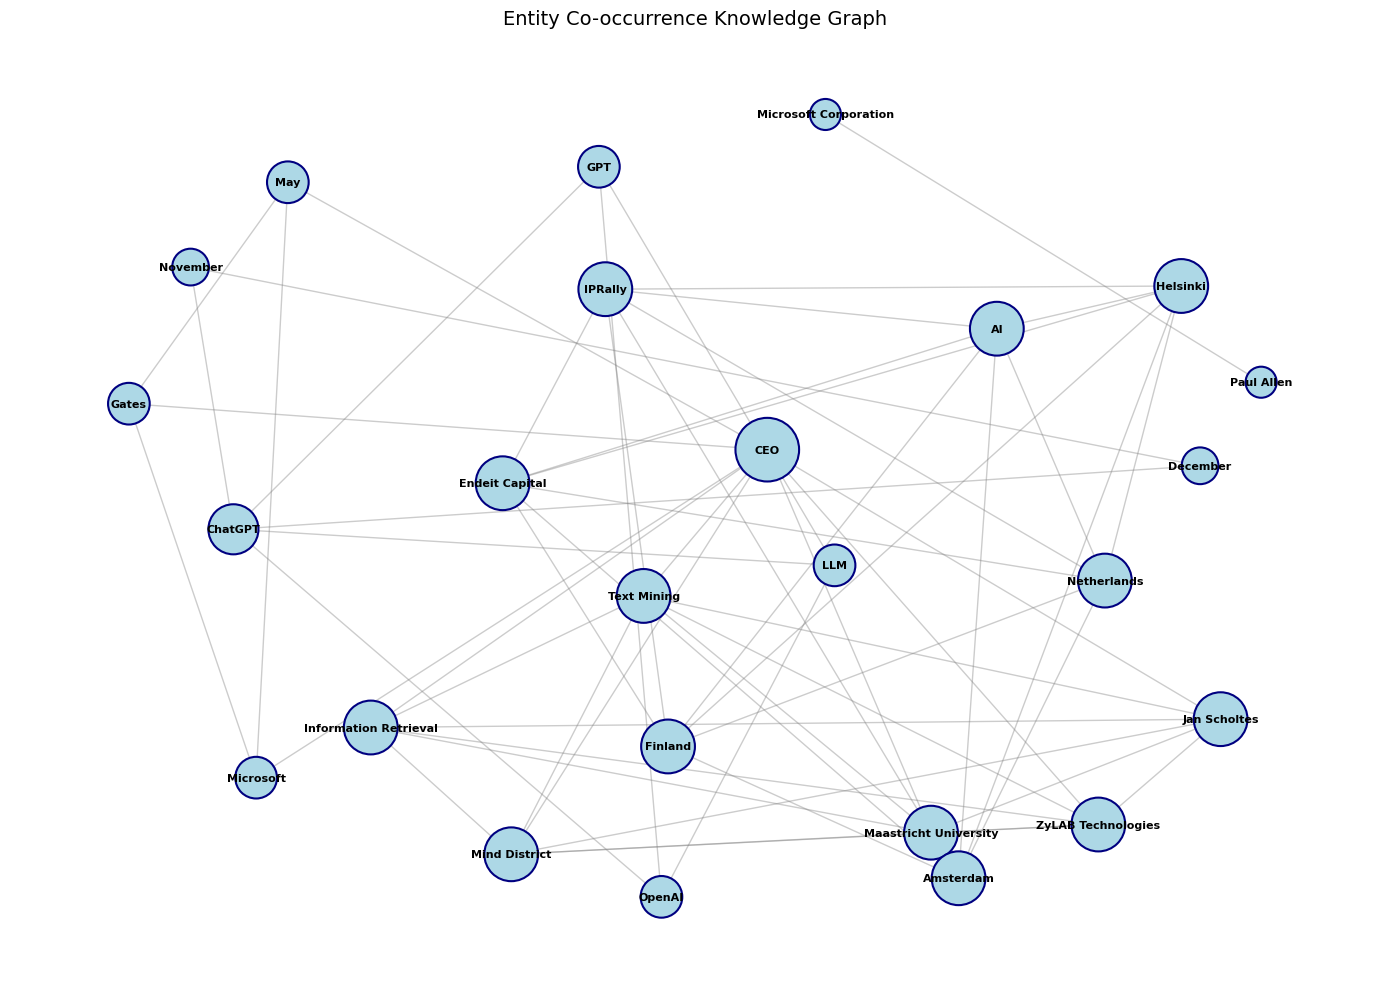

In [202]:
# Visualize the knowledge graph
plt.figure(figsize=(14, 10))

# Use spring layout for positioning
pos = nx.spring_layout(G, k=2, seed=42)

# Node sizes based on degree (connectivity)
node_sizes = [300 + 200 * G.degree(node) for node in G.nodes()]

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', edgecolors='navy', linewidths=1.5)
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

plt.title("Entity Co-occurrence Knowledge Graph", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## 6.3 Using BERT NER for Better Knowledge Graphs

We can improve our knowledge graph by using BERT-based NER to identify entities more accurately, and then build the graph from those entities.

BERT Knowledge Graph: 27 nodes, 63 edges


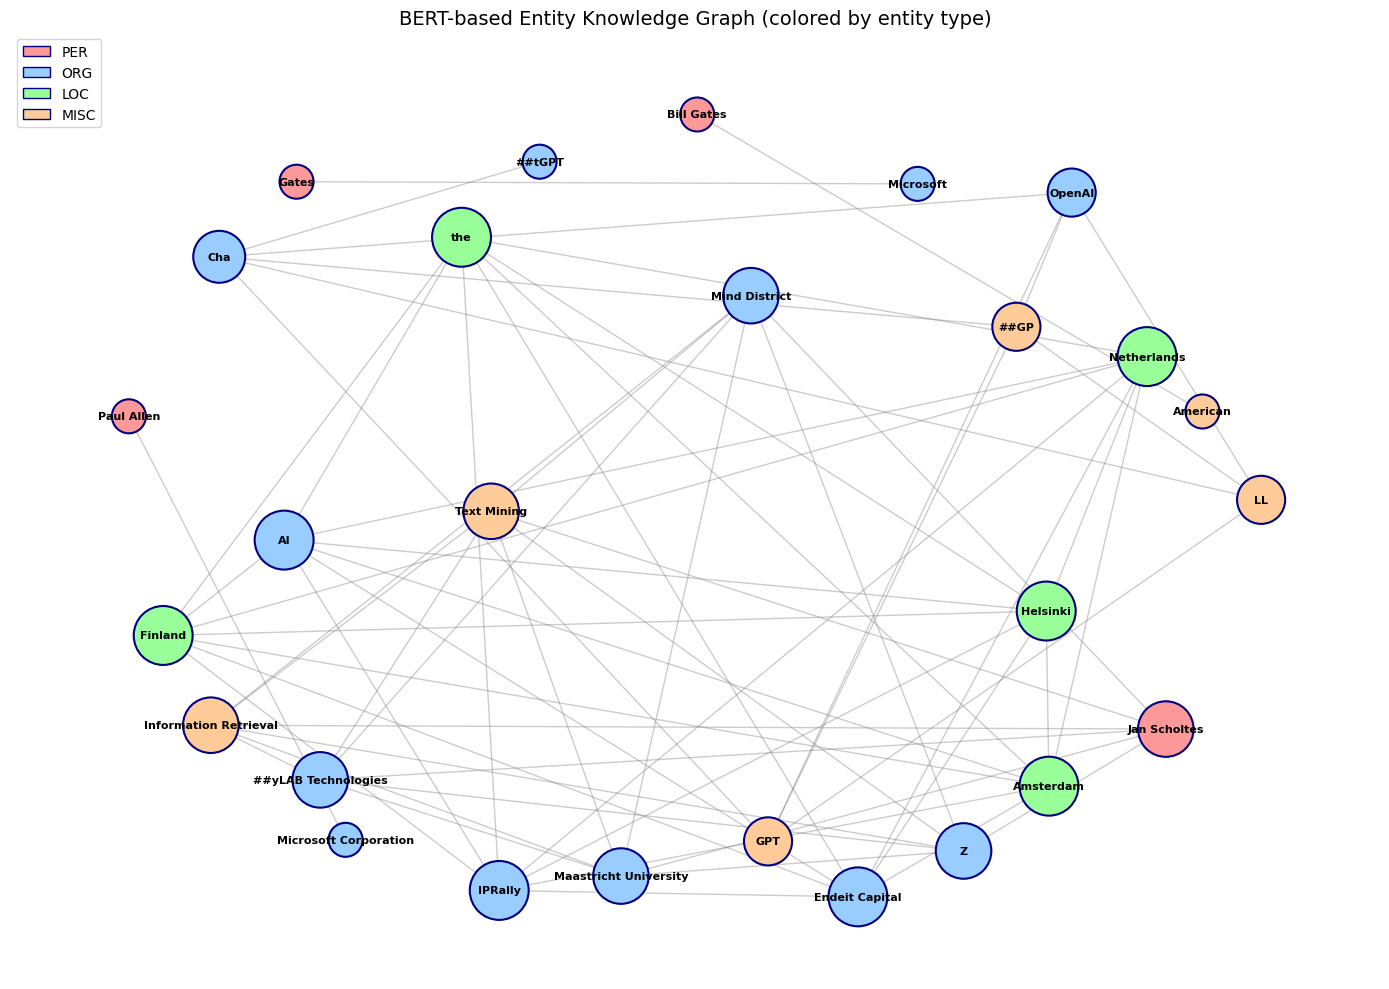

In [203]:
# Use BERT NER results to build a typed knowledge graph
G_bert = nx.Graph()

# Group NER results by sentence
sentences = sent_tokenize(article)
for sent in sentences:
    sent_ner = ner_pipeline(sent)
    entities_in_sent = [(r['word'], r['entity_group']) for r in sent_ner]
    
    # Add typed nodes
    for word, etype in entities_in_sent:
        G_bert.add_node(word, entity_type=etype)
    
    # Connect entities within the same sentence
    for i in range(len(entities_in_sent)):
        for j in range(i + 1, len(entities_in_sent)):
            G_bert.add_edge(entities_in_sent[i][0], entities_in_sent[j][0])

print(f"BERT Knowledge Graph: {G_bert.number_of_nodes()} nodes, {G_bert.number_of_edges()} edges")

# Color nodes by entity type
color_map = {'PER': '#ff9999', 'ORG': '#99ccff', 'LOC': '#99ff99', 'MISC': '#ffcc99'}
node_colors = [color_map.get(G_bert.nodes[n].get('entity_type', ''), '#dddddd') for n in G_bert.nodes()]

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_bert, k=2.5, seed=42)
node_sizes = [400 + 200 * G_bert.degree(node) for node in G_bert.nodes()]

nx.draw_networkx_nodes(G_bert, pos, node_size=node_sizes, node_color=node_colors, edgecolors='navy', linewidths=1.5)
nx.draw_networkx_edges(G_bert, pos, alpha=0.4, edge_color='gray')
nx.draw_networkx_labels(G_bert, pos, font_size=8, font_weight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, edgecolor='navy', label=t) for t, c in color_map.items()]
plt.legend(handles=legend_elements, loc='upper left', fontsize=10)

plt.title("BERT-based Entity Knowledge Graph (colored by entity type)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## 6.4 Searching Knowledge Graphs

Once built, knowledge graphs can be queried using:
- **Cypher** (Neo4j) — for high-performance pattern matching and traversals in property graphs
- **SPARQL** (RDF) — for semantic queries over triple stores following web standards

For example, in Cypher:
```
MATCH (p:Person)-[:WORKS_FOR]->(o:Organization)
RETURN p.name, o.name
```

And in SPARQL:
```sparql
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
SELECT ?name ?email
WHERE {
    ?person a foaf:Person .
    ?person foaf:name ?name .
    ?person foaf:mbox ?email .
}
```

**Key difference:** Neo4j/Cypher excels at deep multi-hop traversals, while RDF/SPARQL is better for linking knowledge across diverse data sources.

In the upcoming lectures on **RAG (Retrieval-Augmented Generation)**, we will see how knowledge graphs combined with vector search can significantly improve conversational search and reduce LLM hallucinations.

---
# 7. Applied Pipeline: Knowledge Graph from Your Corpus

In Tutorial 03, you built a search engine over a text corpus (the default was *The Adventures of Sherlock Holmes* from Project Gutenberg). The text was chunked into paragraphs and saved as `.txt` files in `custom_corpus/chunks/`.

Now we apply the NER and KG techniques from Sections 1–6 to that **real corpus** to build a Knowledge Graph that captures entities and their relationships across the entire text.

**Pipeline:**

```
Sherlock Holmes chunks (from Tutorial 03)
        ↓
   BERT NER → extract entities per chunk
        ↓
   Co-occurrence → extract (entity₁, co-occurs_with, entity₂) triples
        ↓
   NetworkX KG → visualize entity network
        ↓
   Save KG to disk → reuse in Tutorial 11
```

## 7.1 Load the Corpus Chunks

In [204]:
# Load the corpus chunks created in Tutorial 03 (Section 10)
CHUNKS_DIR = os.path.join("custom_corpus", "chunks")

if not os.path.isdir(CHUNKS_DIR):
    raise FileNotFoundError(
        f"'{CHUNKS_DIR}' not found. Please run Tutorial 03 Section 10 first "
        "to download and chunk the Sherlock Holmes text."
    )

chunk_files = sorted(glob.glob(os.path.join(CHUNKS_DIR, "*.txt")))
corpus_chunks = []
for fpath in chunk_files:
    with open(fpath, "r", encoding="utf-8") as f:
        text = f.read().strip()
        if len(text) > 20:  # Skip tiny fragments
            corpus_chunks.append(text)

print(f"Loaded {len(corpus_chunks)} chunks from {CHUNKS_DIR}")
print(f"Average chunk length: {np.mean([len(c.split()) for c in corpus_chunks]):.0f} words")
print(f"\nSample chunk (first one):\n{corpus_chunks[0][:300]}...")

Loaded 2287 chunks from custom_corpus\chunks
Average chunk length: 46 words

Sample chunk (first one):
The Adventures of Sherlock Holmes by Arthur Conan Doyle Contents I. A Scandal in Bohemia II. The Red-Headed League III. A Case of Identity IV. The Boscombe Valley Mystery V. The Five Orange Pips VI. The Man with the Twisted Lip...


## 7.2 Extract Entities with BERT NER

We use the `dslim/bert-base-NER` pipeline (from Section 3) to extract named entities from every chunk. We then aggregate entity counts to see who and what appears most often in the corpus.

In [205]:
# Run BERT NER on all corpus chunks
# We reuse the ner_pipeline from Section 3 (dslim/bert-base-NER)
# If it hasn't been loaded yet, load it:
try:
    _ = ner_pipeline
except NameError:
    ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

def extract_entities_from_chunks(chunks, ner_pipe, max_length=512, sample_size=None):
    """Extract named entities from corpus chunks using BERT NER.
    
    Returns:
        entities_per_chunk: list of lists — entities found in each chunk
        entity_counts: Counter — global entity frequency
    """
    if sample_size and sample_size < len(chunks):
        indices = random.sample(range(len(chunks)), sample_size)
        selected = [(i, chunks[i]) for i in sorted(indices)]
    else:
        selected = list(enumerate(chunks))
    
    entities_per_chunk = {}
    entity_counts = Counter()
    
    for idx, chunk in selected:
        # Truncate to avoid BERT 512-token limit
        truncated = " ".join(chunk.split()[:max_length])
        try:
            ner_results = ner_pipe(truncated)
        except Exception:
            ner_results = []
        
        chunk_entities = []
        for ent in ner_results:
            name = ent["word"].strip().replace(" ##", "")
            label = ent["entity_group"]
            if len(name) > 1:  # Skip single-char entities
                chunk_entities.append((name, label))
                entity_counts[name] += 1
        
        entities_per_chunk[idx] = chunk_entities
    
    return entities_per_chunk, entity_counts

# Process a sample of chunks (full corpus may take a few minutes)
SAMPLE_SIZE = 300  # Increase for more complete KG; set to None for all chunks
entities_per_chunk, entity_counts = extract_entities_from_chunks(
    corpus_chunks, ner_pipeline, sample_size=SAMPLE_SIZE
)

print(f"Processed {len(entities_per_chunk)} chunks")
print(f"Unique entities found: {len(entity_counts)}")
print(f"\nTop-20 most frequent entities:")
for name, count in entity_counts.most_common(20):
    print(f"  {name:30s} — {count:3d} occurrences")

NameError: name 'Counter' is not defined

## 7.3 Build Co-occurrence Knowledge Graph

We build a KG based on **entity co-occurrence**: if two entities appear in the same chunk, they are likely related. We weight edges by how often they co-occur.

This is a simple but effective approach that captures the social and geographic network within a narrative text.

In [ ]:
# Build a co-occurrence KG from entity-per-chunk data
from itertools import combinations

def build_cooccurrence_kg(entities_per_chunk, min_entity_freq=2, min_edge_weight=2):
    """Build a KG where entities that co-occur in a chunk share an edge.
    
    Args:
        entities_per_chunk: dict mapping chunk_idx → [(name, label), ...]
        min_entity_freq: minimum number of occurrences to include an entity
        min_edge_weight: minimum co-occurrence count for an edge
    
    Returns:
        G: NetworkX graph with entities as nodes and co-occurrences as edges
    """
    # Count global entity frequencies
    global_counts = Counter()
    for ents in entities_per_chunk.values():
        for name, _ in ents:
            global_counts[name] += 1
    
    # Filter to frequent entities
    frequent = {name for name, count in global_counts.items() if count >= min_entity_freq}
    
    # Count co-occurrences
    edge_counts = Counter()
    for ents in entities_per_chunk.values():
        # Unique entity names in this chunk
        names = list(set(name for name, _ in ents if name in frequent))
        for a, b in combinations(sorted(names), 2):
            edge_counts[(a, b)] += 1
    
    # Build graph
    G = nx.Graph()
    
    # Add nodes with entity type info
    entity_labels = {}
    for ents in entities_per_chunk.values():
        for name, label in ents:
            if name in frequent:
                entity_labels[name] = label
    
    for name, label in entity_labels.items():
        G.add_node(name, entity_type=label, frequency=global_counts[name])
    
    # Add edges
    for (a, b), weight in edge_counts.items():
        if weight >= min_edge_weight:
            G.add_edge(a, b, weight=weight)
    
    return G

G_corpus = build_cooccurrence_kg(entities_per_chunk, min_entity_freq=3, min_edge_weight=2)

print(f"Knowledge Graph built:")
print(f"  Nodes (entities): {G_corpus.number_of_nodes()}")
print(f"  Edges (co-occurrences): {G_corpus.number_of_edges()}")

# Show top connected entities
degree_sorted = sorted(G_corpus.degree(), key=lambda x: x[1], reverse=True)[:15]
print(f"\nMost connected entities:")
for name, degree in degree_sorted:
    etype = G_corpus.nodes[name].get("entity_type", "?")
    freq = G_corpus.nodes[name].get("frequency", 0)
    print(f"  {name:25s} type={etype:5s}  connections={degree:3d}  mentions={freq:3d}")

## 7.4 Visualize the Corpus Knowledge Graph

Let's visualize the character and location network from the Sherlock Holmes stories. Node size reflects mention frequency, edge thickness reflects co-occurrence strength, and node colour indicates entity type.

In [ ]:
# Visualize the corpus KG
color_map = {"PER": "#1f77b4", "LOC": "#2ca02c", "ORG": "#ff7f0e", "MISC": "#d62728"}

# Take the largest connected component for a cleaner visualization
if G_corpus.number_of_nodes() > 0:
    components = sorted(nx.connected_components(G_corpus), key=len, reverse=True)
    G_vis = G_corpus.subgraph(components[0]).copy() if components else G_corpus
else:
    G_vis = G_corpus

# Limit to top-40 nodes by degree for readability
if G_vis.number_of_nodes() > 40:
    top_nodes = [n for n, _ in sorted(G_vis.degree(), key=lambda x: x[1], reverse=True)[:40]]
    G_vis = G_vis.subgraph(top_nodes).copy()

fig, ax = plt.subplots(figsize=(14, 10))

# Node properties
node_colors = [color_map.get(G_vis.nodes[n].get("entity_type", "MISC"), "#999999") for n in G_vis.nodes()]
node_sizes = [G_vis.nodes[n].get("frequency", 1) * 40 + 100 for n in G_vis.nodes()]

# Edge properties
edge_weights = [G_vis[u][v].get("weight", 1) for u, v in G_vis.edges()]
max_w = max(edge_weights) if edge_weights else 1
edge_widths = [1 + 3 * (w / max_w) for w in edge_weights]

pos = nx.spring_layout(G_vis, k=2.5, iterations=50, seed=SEED)

nx.draw_networkx_edges(G_vis, pos, ax=ax, width=edge_widths, alpha=0.3, edge_color="#888888")
nx.draw_networkx_nodes(G_vis, pos, ax=ax, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_labels(G_vis, pos, ax=ax, font_size=8, font_weight="bold")

# Legend
from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=t)
                  for t, c in color_map.items()]
ax.legend(handles=legend_handles, loc="upper left", fontsize=10, title="Entity Type")

ax.set_title("Knowledge Graph: Sherlock Holmes Entity Co-occurrence Network", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

print(f"\nVisualized {G_vis.number_of_nodes()} nodes and {G_vis.number_of_edges()} edges")

In [ ]:
# Save the KG to disk so Tutorial 11 can load it
KG_DIR = os.path.join("custom_corpus", "kg")
os.makedirs(KG_DIR, exist_ok=True)

# Save as edge list with attributes
kg_data = {
    "nodes": [
        {"name": n, "entity_type": G_corpus.nodes[n].get("entity_type", "UNK"),
         "frequency": G_corpus.nodes[n].get("frequency", 0)}
        for n in G_corpus.nodes()
    ],
    "edges": [
        {"source": u, "target": v, "weight": G_corpus[u][v].get("weight", 1)}
        for u, v in G_corpus.edges()
    ],
}

kg_path = os.path.join(KG_DIR, "sherlock_kg.json")
with open(kg_path, "w", encoding="utf-8") as f:
    json.dump(kg_data, f, indent=2)

print(f"Knowledge Graph saved to {kg_path}")
print(f"  {len(kg_data['nodes'])} nodes, {len(kg_data['edges'])} edges")

---
# 8. RAG Retrieval Foundation: FAISS Vector Store

To build a RAG chatbot in Tutorial 11, we need a **dense retrieval index** over our corpus. Here we:

1. **Embed** every chunk using a sentence-transformer bi-encoder (`all-MiniLM-L6-v2`)
2. **Index** all embeddings in a FAISS vector store for fast nearest-neighbour search
3. **Test** the index with sample queries
4. **Save** the index and embeddings to disk

This is the same approach used in production RAG systems (e.g., LangChain, LlamaIndex).

$$\text{similarity}(q, d) = \frac{\vec{q} \cdot \vec{d}}{\|\vec{q}\| \, \|\vec{d}\|}$$

## 8.1 Embed the Corpus

In [ ]:
# Load the bi-encoder model
bi_encoder = SentenceTransformer("all-MiniLM-L6-v2")
print(f"Model: all-MiniLM-L6-v2  (embedding dim: {bi_encoder.get_sentence_embedding_dimension()})")

# Embed all corpus chunks
print(f"Embedding {len(corpus_chunks)} chunks...")
chunk_embeddings = bi_encoder.encode(
    corpus_chunks,
    show_progress_bar=True,
    convert_to_numpy=True,
    batch_size=64,
)
print(f"Embeddings shape: {chunk_embeddings.shape}")

## 8.2 Build FAISS Index

FAISS (Facebook AI Similarity Search) provides highly optimized vector search. We use `IndexFlatIP` (inner product on normalized vectors = cosine similarity) which is exact but fast enough for our corpus size.

In [ ]:
# Build the FAISS index
dim = chunk_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(dim)

# Normalize embeddings for cosine similarity via inner product
chunk_embeddings_norm = chunk_embeddings.copy()
faiss.normalize_L2(chunk_embeddings_norm)
faiss_index.add(chunk_embeddings_norm)

print(f"FAISS index built: {faiss_index.ntotal} vectors, dimension={dim}")

# Test with sample queries
test_queries = [
    "Who is Sherlock Holmes?",
    "What happened at the crime scene?",
    "Where does Watson live?",
    "Tell me about Irene Adler",
    "mysterious letter delivered at night",
]

print(f"\n{'='*70}")
print("Dense retrieval test (top-3 per query):\n")

for query in test_queries:
    q_emb = bi_encoder.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_emb)
    scores, indices = faiss_index.search(q_emb, 3)
    
    print(f"Query: \"{query}\"")
    for rank, (idx, score) in enumerate(zip(indices[0], scores[0])):
        preview = corpus_chunks[idx][:100].replace("\n", " ")
        print(f"  [{rank+1}] score={score:.4f}  \"{preview}...\"")
    print()

## 8.3 Save Index & Embeddings to Disk

We save the FAISS index, the raw embeddings, and the chunk texts so Tutorial 11 can load them directly without re-computing.

In [ ]:
# Save FAISS index, embeddings, and chunk texts for reuse in Tutorial 11
VECTOR_DIR = os.path.join("custom_corpus", "vector_store")
os.makedirs(VECTOR_DIR, exist_ok=True)

# Save FAISS index
faiss.write_index(faiss_index, os.path.join(VECTOR_DIR, "faiss_index.bin"))

# Save raw embeddings (unnormalized, so they can be used flexibly)
np.save(os.path.join(VECTOR_DIR, "chunk_embeddings.npy"), chunk_embeddings)

# Save chunk texts as JSON for easy loading
with open(os.path.join(VECTOR_DIR, "chunks.json"), "w", encoding="utf-8") as f:
    json.dump(corpus_chunks, f, indent=2, ensure_ascii=False)

print(f"Saved to {VECTOR_DIR}:")
print(f"  faiss_index.bin         — FAISS index ({faiss_index.ntotal} vectors)")
print(f"  chunk_embeddings.npy    — embeddings array {chunk_embeddings.shape}")
print(f"  chunks.json             — {len(corpus_chunks)} chunk texts")

---
# 9. Atomic Facts & QA Test Set for RAGAS Evaluation

To evaluate a RAG system, we need a **test set** of questions, expected answers, and **atomic facts** — individual verifiable claims decomposed from text passages. The RAGAS framework (Tutorial 11) uses these to measure **faithfulness** and **hallucination**.

## What are Atomic Facts?

An **atomic fact** (or atomic claim) is the smallest independently verifiable statement extracted from a passage:

| Original Passage | Atomic Facts |
|---|---|
| "Sherlock Holmes lives at 221B Baker Street in London and works as a consulting detective." | 1. Sherlock Holmes lives at 221B Baker Street. |
| | 2. 221B Baker Street is in London. |
| | 3. Sherlock Holmes works as a consulting detective. |

These decomposed claims become the ground truth for measuring whether a RAG-generated answer is faithful to the source material.

## 9.1 Extract Atomic Facts from Corpus

In [ ]:
# Extract atomic facts from corpus chunks using sentence splitting + NER-based filtering
# We keep sentences that contain at least one named entity — these are verifiable claims.

def extract_atomic_facts(chunks, ner_pipe, max_facts_per_chunk=5, max_chunks=200):
    """Extract atomic facts (verifiable claims) from corpus chunks.
    
    Strategy: Split chunks into sentences, keep those with named entities.
    This gives us factual/narrative statements rather than background description.
    """
    all_facts = []
    
    sample = chunks[:max_chunks]  # Use first N chunks for determinism
    
    for chunk_idx, chunk in enumerate(sample):
        sentences = sent_tokenize(chunk)
        
        for sent in sentences:
            sent = sent.strip()
            if len(sent.split()) < 5 or len(sent.split()) > 60:
                continue  # Skip very short or very long sentences
            
            # Check if sentence contains named entities
            try:
                ents = ner_pipe(sent[:512])
            except Exception:
                ents = []
            
            entity_names = [e["word"].strip() for e in ents if len(e["word"].strip()) > 1]
            
            if entity_names:
                all_facts.append({
                    "fact": sent,
                    "chunk_idx": chunk_idx,
                    "entities": entity_names,
                })
            
            if len(all_facts) >= max_chunks * max_facts_per_chunk:
                break
    
    return all_facts

print("Extracting atomic facts from corpus (this may take a minute)...")
atomic_facts = extract_atomic_facts(corpus_chunks, ner_pipeline, max_facts_per_chunk=5, max_chunks=150)

print(f"\nExtracted {len(atomic_facts)} atomic facts from the corpus")
print(f"\nSample atomic facts:")
for fact in atomic_facts[:10]:
    ents = ", ".join(fact["entities"][:3])
    print(f"  [{fact['chunk_idx']:3d}] ({ents})")
    print(f"        \"{fact['fact'][:120]}...\"" if len(fact['fact']) > 120 else f"        \"{fact['fact']}\"")
    print()

## 9.2 Generate QA Test Set

We generate question-answer pairs from our atomic facts using **template-based question generation**. Each fact becomes an expected answer, and we create a question that should retrieve the corresponding chunk.

These QA pairs will be used in Tutorial 11 to evaluate the RAG chatbot with RAGAS metrics.

In [ ]:
# Generate QA pairs from atomic facts using template-based question generation

QUESTION_TEMPLATES = [
    "What do we know about {entity}?",
    "What happened involving {entity}?",
    "Tell me about {entity} in the story.",
    "What is the role of {entity}?",
    "What did {entity} do?",
]

def generate_qa_pairs(atomic_facts, max_pairs=50):
    """Generate question-answer pairs from atomic facts.
    
    For each fact, create a question about one of its entities.
    The expected answer is the original fact sentence.
    The ground-truth chunk is the source chunk.
    """
    qa_pairs = []
    used_entities = set()
    
    for fact_data in atomic_facts:
        if len(qa_pairs) >= max_pairs:
            break
        
        fact = fact_data["fact"]
        chunk_idx = fact_data["chunk_idx"]
        entities = fact_data["entities"]
        
        # Pick an entity we haven't used much
        for entity in entities:
            if entity not in used_entities or len(used_entities) > 20:
                template = random.choice(QUESTION_TEMPLATES)
                question = template.format(entity=entity)
                
                qa_pairs.append({
                    "question": question,
                    "ground_truth_answer": fact,
                    "ground_truth_chunk_idx": chunk_idx,
                    "ground_truth_context": corpus_chunks[chunk_idx],
                    "entity": entity,
                })
                used_entities.add(entity)
                break
    
    return qa_pairs

qa_test_set = generate_qa_pairs(atomic_facts, max_pairs=50)

print(f"Generated {len(qa_test_set)} QA test pairs\n")
print("Sample QA pairs:")
for qa in qa_test_set[:8]:
    print(f"  Q: {qa['question']}")
    print(f"  A: \"{qa['ground_truth_answer'][:100]}...\"" if len(qa['ground_truth_answer']) > 100 
          else f"  A: \"{qa['ground_truth_answer']}\"")
    print(f"  Source chunk: {qa['ground_truth_chunk_idx']}")
    print()

## 9.3 Save Atomic Facts & QA Set to Disk

We save everything to `custom_corpus/evaluation/` so Tutorial 11 can load these artifacts for RAGAS evaluation.

In [ ]:
# Save atomic facts and QA test set for Tutorial 11
EVAL_DIR = os.path.join("custom_corpus", "evaluation")
os.makedirs(EVAL_DIR, exist_ok=True)

# Save atomic facts
atomic_facts_path = os.path.join(EVAL_DIR, "atomic_facts.json")
with open(atomic_facts_path, "w", encoding="utf-8") as f:
    json.dump(atomic_facts, f, indent=2, ensure_ascii=False)

# Save QA test set
qa_path = os.path.join(EVAL_DIR, "qa_test_set.json")
with open(qa_path, "w", encoding="utf-8") as f:
    json.dump(qa_test_set, f, indent=2, ensure_ascii=False)

print(f"Saved to {EVAL_DIR}:")
print(f"  atomic_facts.json  — {len(atomic_facts)} verifiable claims")
print(f"  qa_test_set.json   — {len(qa_test_set)} question-answer pairs")
print(f"\nThese files will be loaded in Tutorial 11 for RAGAS evaluation.")

# Summary of all saved artifacts across tutorials
print(f"\n{'='*60}")
print("Cross-tutorial data pipeline summary:")
print(f"  Tutorial 03 → custom_corpus/chunks/           ({len(corpus_chunks)} text chunks)")
print(f"  Tutorial 07 → custom_corpus/kg/               (Knowledge Graph: {G_corpus.number_of_nodes()} nodes, {G_corpus.number_of_edges()} edges)")
print(f"  Tutorial 07 → custom_corpus/vector_store/     (FAISS index: {faiss_index.ntotal} vectors)")
print(f"  Tutorial 07 → custom_corpus/evaluation/       ({len(atomic_facts)} facts, {len(qa_test_set)} QA pairs)")
print(f"  Tutorial 11 → will load all of the above to build and evaluate a RAG chatbot")

---
# Exercises

The following exercises are graded. Please provide your answers in the designated cells below.

## Exercise 1 — NER: Traditional vs. BERT (5 points)

Compare traditional Named Entity Recognition approaches (HMM, CRF) with BERT-based approaches. In your answer, address the following:

1. What are the main limitations of traditional approaches (HMM, CRF) for NER?
2. How does BERT's architecture (bidirectional self-attention, WordPiece tokenization) address these limitations?
3. Why might traditional approaches still be preferred in certain production scenarios?

Write your answer in the cell below (minimum 150 words).

BEGIN SOLUTION

END SOLUTION

YOUR ANSWER HERE

## Exercise 2 — Knowledge Graphs from Text (5 points)

Describe the 4-step pipeline for building Knowledge Graphs from unstructured text. In your answer, address:

1. Explain each of the four steps: Co-reference Resolution, NER & Normalization, Relationship Extraction, and KG Construction.
2. What role does entity normalization play? Give an example of how failing to normalize entities can lead to a fragmented knowledge graph.
3. How can pre-trained BERT models improve each step of this pipeline?

Write your answer in the cell below (minimum 150 words).

BEGIN SOLUTION

END SOLUTION

YOUR ANSWER HERE

## Exercise 3 — Fine-tune BERT for POS Tagging (10 points)

Adapt the NER fine-tuning code from Section 4 to fine-tune `bert-base-uncased` on **POS tagging** instead of NER. The CoNLL-2003 dataset contains POS tags in addition to NER tags.

Your task:
1. Load the CoNLL-2003 dataset and use the `pos_tags` column instead of `ner_tags`
2. Create the label alignment function for POS tags
3. Fine-tune the model for 2 epochs
4. Evaluate and report precision, recall, F1-score, and accuracy

Write your code in the cell below.

BEGIN SOLUTION

END SOLUTION

In [ ]:
# YOUR CODE HERE
raise NotImplementedError("Replace this line with your solution")

NotImplementedError: Replace this line with your solution

In [ ]:
# Autograder test cell — do not modify
# This cell checks that your model has been trained and produces predictions
assert 'model_pos' in dir() or 'trainer_pos' in dir(), "You need to create a model or trainer for POS tagging"
print("Basic check passed. Your solution will be manually reviewed for correctness.")

## Exercise 4 — Build a KG & RAG Foundation from Your Own Corpus (15 points)

In Tutorial 03 (Exercise 4), you built a search engine over your own text corpus. Now, replicate the pipeline from Sections 7–9 on **your own data**.

Your task:
1. **Load your corpus chunks** from `custom_corpus/chunks/` (or wherever Tutorial 03 saved them). If you used the default Sherlock Holmes text, choose a different text for this exercise. *(2 pts)*
2. **Run BERT NER** on at least 100 chunks and build a **co-occurrence Knowledge Graph**. Print the top-10 entities and the number of nodes/edges. *(4 pts)*
3. **Embed your chunks** with `all-MiniLM-L6-v2` and build a **FAISS index**. Test it with 3 domain-specific queries and print the top-3 results for each. *(4 pts)*
4. **Extract at least 30 atomic facts** and generate at least 20 **QA test pairs**. Save everything to `custom_corpus/evaluation/`. *(3 pts)*
5. **Briefly describe** (in a markdown cell, minimum 100 words) how the quality of your KG and atomic facts depends on the quality of the NER model and the text domain. What works well? What fails? *(2 pts)*

Store your final KG as `my_kg` (NetworkX graph), your FAISS index as `my_faiss_index`, and your QA pairs as `my_qa_pairs` (list of dicts).

BEGIN SOLUTION

END SOLUTION

In [ ]:
# YOUR CODE HERE — Exercise 4
# Follow the steps outlined above. You can reuse all functions from Sections 7–9.
# Store your results in: my_kg, my_faiss_index, my_qa_pairs

raise NotImplementedError("Replace this line with your solution")

YOUR REFLECTION HERE (minimum 100 words on NER quality, KG quality, domain effects)

In [ ]:
# Autograder test cell — do not modify
assert 'my_kg' in dir(), "You need to create 'my_kg' (a NetworkX graph)"
assert 'my_faiss_index' in dir(), "You need to create 'my_faiss_index' (a FAISS index)"
assert 'my_qa_pairs' in dir(), "You need to create 'my_qa_pairs' (a list of QA dicts)"
assert isinstance(my_kg, nx.Graph), "my_kg should be a NetworkX Graph"
assert my_kg.number_of_nodes() >= 5, "my_kg should have at least 5 nodes"
assert my_faiss_index.ntotal >= 10, "my_faiss_index should contain at least 10 vectors"
assert len(my_qa_pairs) >= 20, "my_qa_pairs should contain at least 20 QA pairs"
assert all('question' in q and 'ground_truth_answer' in q for q in my_qa_pairs), \
    "Each QA pair must have 'question' and 'ground_truth_answer' keys"
print(f"KG: {my_kg.number_of_nodes()} nodes, {my_kg.number_of_edges()} edges")
print(f"FAISS index: {my_faiss_index.ntotal} vectors")
print(f"QA pairs: {len(my_qa_pairs)}")
print("All auto-graded tests passed!")